# Model objects and predicting whole brain activity

Model objects are supereeg's class that contains the model that reconstructs full brain activity timeseries from a smaller sample of electrodes. The supereeg package offers a few premade models that you can use to reconstruct brain activity, but also a way to create your own model if you have a dataset of intracranial patient data converted into the brain object format.  This tutorial will go over how to use the premade models included in this package, as well as make a new model from scratch.

# Load in the required libraries

In [1]:
# import warnings 
# warnings.simplefilter("ignore")
import supereeg as se
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image
import numpy as np

First, let's load in our default model, `example_model`, that we made from the pyFR dataset sampled at 20mm resolution. Electrodes with a threshold exceeding 10 were removed from the dataset, and the radial basis function of with a width of 20 mm was used to 'fill in' nearby electrode sites during the model creation.

In [2]:
model = se.load('example_model')

other model options:

`pyFR_k10r20_6mm`

`pyFR_k10r20_20mm`  

Note: The last option is the same as the example_model, but saved as `.npz` instead of `.mo`.


# Model object methods

There are a few other useful methods on a brain object:

## `mo.info()`

This method will give you a summary of the brain object:

In [3]:
model.info()

Number of locations: 170
Number of subjects: 66
Date created: Tue Dec 19 06:13:33 2017
Meta data: None


## `mo.plot()`

This method will plot your model.  

The model is comprised of a number of fields.  The most important are the `model.numerator` and `model.denominator`.  Dividing these two fields gives a matrix of z-values, where the value in each cell represents the covariance between every model brain location with every other model brain location. To view the model, simply call the `model.plot` method.  This method wraps `seaborn.heatmap` to plot the model (transformed from z to r), so any arguments that `seaborn.heatmap` accepts are supported by `model.plot`.

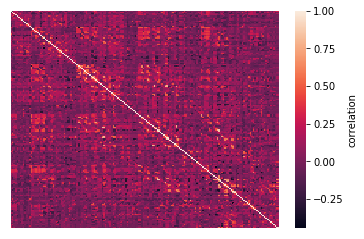

In [4]:
model.plot(xticklabels=False, yticklabels=False)
plt.show()

## `mo.update()`

This method allows you to update the model with addition subject data. 

To do this, we can use the `update` method, passing a new subjects data as a brain object. First, let's load in an example subjects data:

In [5]:
bo = se.load('example_data')
bo.info()

Number of electrodes: 64
Recording time in seconds: [[  5.3984375  14.1328125]]
Number of sessions: 2
Date created: Thu Feb  8 12:21:58 2018
Meta data: CH003


Now you can update the model with that brain object:

In [6]:
updated_model = model.update(bo)
updated_model.info()

Number of locations: 170
Number of subjects: 67
Date created: Thu Feb  8 12:21:59 2018
Meta data: None


Note that the model is now comprised of 67 subjects, instead of 66 before we updated it.

## `mo.save(fname='something')`
This method will save the brain object to the specified file location.
The data will be saved as a 'bo' file, which is a dictionary containing the elements of a brain object saved in the hd5 format using `deepdish`.

In [7]:
#mo.save(fname='model_object')

## Creating a new model

In addition to including a few premade models in the `supereeg` package, we also provide a way to construct a model from scratch. 

### Created from a list of brain objects:
For example, if you have a dataset of iEEG patients, we provide a way to construct a model that will predict whole brain activity.  The more subjects you include in the model, the better it will be! To create a model, first you'll need to format your subject data into brain objects.  For the purpose of demonstration, we will simulate 10 subjects and construct the model from that data:

In [8]:
# load locations
locs = se.load('example_locations')

# simulate 10 brain objects to create a model
n_subs = 10
model_bos = [se.simulate_model_bos(n_samples=1000, sample_rate=1000, sample_locs=20, 
                                   locs=locs, cov='toeplitz') for x in range(n_subs)]

model_bos[0].info()

/Users/lucyowen/repos/superEEG/supereeg/simulate.py:163: RuntimeWarning: covariance is not positive-semidefinite.
  full_data = np.random.multivariate_normal(np.zeros(len(locs)), R, size=n_samples)


Number of electrodes: 20
Recording time in seconds: [ 1.]
Number of sessions: 1
Date created: Thu Feb  8 12:22:00 2018
Meta data: {}


As you can see above, each simulated subject has 10 (randomly placed) 'electrodes', with 1 second of data each. To construct a model from these brain objects, simply pass them to the `se.Model` class, and a new model will be generated:

In [9]:
new_model = se.Model(data=model_bos, locs=locs)
new_model.info()

Number of locations: 170
Number of subjects: 10
Date created: Thu Feb  8 12:22:05 2018
Meta data: None


### Created by adding to model object fields:

Another option is to add a model directly. 

You can add your model to `model.numerator`, which comprises the sum of the zscored correlation matrices over subjects. The `model.denominator` field comprises the sum of the number of subjects contributing to each matrix cell in the `model.numerator` field. You can add the locations for the model in the field `locs` and the number of subjects to `n_subs`. 

In this next example, we're constructing the model from a toeplitz matrix with 10 subjects. We've updated the `model.numerator` field with the toeplitz matrix created in the function, `se.create_cov`, and locations loaded from `example_locations`. The `model.denominator` field in this case is a matrix of ones, but should be the number of subjects that contributed to each cell in the `model.numerator` field.

You can also create a custom covariance matrix in `se.create_cov` by simply passing numpy array as and that is number of locations by number of locations to `cov` and the number of location to `n_elecs`.  

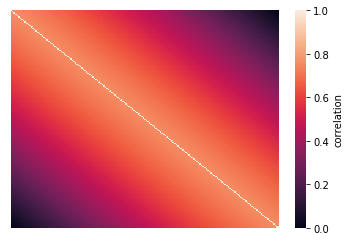

In [10]:
R = se.create_cov(cov='toeplitz', n_elecs=len(locs))
p = 10
model = se.Model(numerator=R, denominator=np.ones(np.shape(R)), locs=locs, n_subs=p)
model.plot(xticklabels=False, yticklabels=False)
plt.show()

In this example we passed a numpy array of custom MNI locations to predict.  

However coordinates can also be derived by specifiying a `template` nifti file.  By default, the model is in MNI coordinates with 20mm resolution, but this can be easily switched to a different space using some templates we include in the package (6mm, 8mm, 20mm), or your own custom space (note: the model space MUST be in MNI coordinates).

In [11]:
# new_model = se.Model(bos, template='/your/custom/MNI_template.nii')

## Predicting whole brain activity

## `mo.predict()`

Now for the magic. `supereeg` uses **_gaussian process regression_** to infer whole brain activity given a smaller sampling of electrode recordings. To predict activity, simply call the `predict` method of a model and pass the subjects brain activity that you'd like to reconstruct:

## `mo.predict(nearest_neighbor=True)`
As default, the nearest voxel for each subject's electrode location is found and used as revised electrodes location matrix in the prediction. If `nearest_neighbor` is set to `False`, the original locations are used in the prediction.  

## `mo.predict(force_update=False)`
As default, the model is not updated with the subject's correlation matrix.  By setting `force_update` to `True`, you will update the model with the subject's correlation matrix.  

BEFORE
------
Number of electrodes: 64
Recording time in seconds: [[  5.3984375  14.1328125]]
Number of sessions: 2
Date created: Thu Feb  8 12:21:58 2018
Meta data: CH003


/Users/lucyowen/repos/superEEG/supereeg/brain.py:395: UserWarning: Template is None.  Default to using a template with 20mm voxels.
  warnings.warn('Template is None.  Default to using a template with 20mm voxels.')
/Users/lucyowen/repos/superEEG/supereeg/brain.py:416: UserWarning: Voxel sizes of reconstruction and template do not match. Voxel sizes calculated from model locations.
  warnings.warn('Voxel sizes of reconstruction and template do not match. '


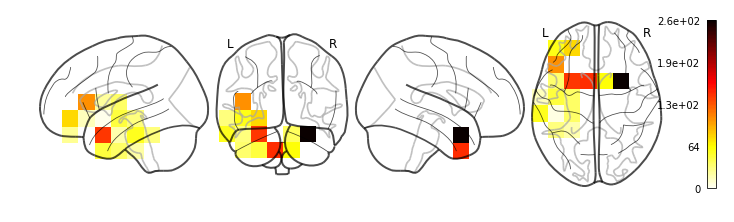

AFTER
------
Number of electrodes: 170
Recording time in seconds: [  5.3984375  14.1328125]
Number of sessions: 2
Date created: Thu Feb  8 12:22:08 2018
Meta data: {}


/Users/lucyowen/repos/superEEG/supereeg/brain.py:399: UserWarning: Template is None.
  warnings.warn('Template is None.')


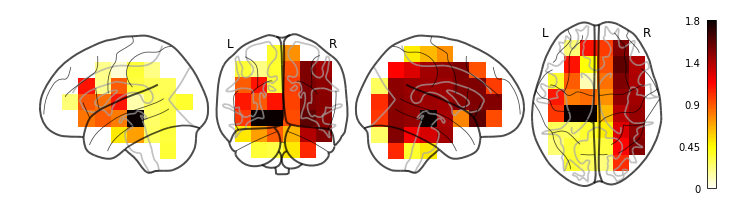

In [12]:
# plot a slice of the original data
print('BEFORE')
print('------')
bo.info()
nii = bo.to_nii()
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0, display_mode='lyrz', threshold=0, colorbar='True')
plotting.show()

# voodoo magic
bor = model.predict(bo)


# plot a slice of the whole brain data
print('AFTER')
print('------')
bor.info()
nii = bor.to_nii()
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0, display_mode='lyrz', threshold=0, colorbar='True')
plotting.show()

Using the `supereeg` algorithm, we've 'reconstructed' whole brain activity from a smaller sample of electrodes. 